# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
pip install --q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 3.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import optuna
import lightgbm
import time
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor
import lightgbm
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/autos.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Посмотрим на важные параметры относительно целевого признака

In [17]:
pip install --q phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 KB 10.8 MB/s eta 0:00:00


In [22]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns

In [20]:
phik_overview = df.phik_matrix()
phik_overview['Price'].round(2).sort_values(ascending=False)

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


Price                1.00
Model                0.57
Power                0.48
Brand                0.36
Repaired             0.34
Kilometer            0.32
Gearbox              0.29
VehicleType          0.27
FuelType             0.27
RegistrationMonth    0.13
RegistrationYear     0.01
Name: Price, dtype: float64

### Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.

In [100]:
df_brand = df.groupby(['Brand'])[['Price']].agg(['count','median']).add_prefix('price_')\
            .droplevel(axis=1,level=0).reset_index()\
            .sort_values(by='price_median', ascending=False).reset_index(drop=True).head(10)
df_brand

,Brand,price_count,price_median
0,porsche,644,12500.0
1,mini,3077,8300.0
2,land_rover,475,8300.0
3,jeep,601,6350.0
4,sonstige_autos,1759,6000.0
5,jaguar,448,5499.5
6,audi,27041,5000.0
7,skoda,5099,5000.0
8,bmw,33824,5000.0
9,dacia,827,4950.0


Из таблицы видно топ-10 самых дорогих автомобилей в выборке

In [103]:
fig = go.Figure(data=[go.Pie(labels=df['Brand'].value_counts().head(10).index, values=df['Brand'].value_counts().head(10),
                             textinfo='label+percent' )])
fig.show()

Топ-10 самых распространенных автомобилей в выборке

In [5]:
df.duplicated().sum()

4

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

0

In [8]:
fig = px.box(df.loc[df['Power']<1000], y="Power")
fig.show()

In [9]:
df = df.loc[(df['Power'] >= 30) & (df['Power'] <= 600)]

In [10]:
df = df.drop(['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen','DateCreated'], axis = 1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [11]:
df.isna().mean().sort_values(ascending=False)

Repaired             0.157779
VehicleType          0.072556
FuelType             0.067148
Model                0.041822
Gearbox              0.020486
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
dtype: float64

In [12]:
cat_columns = list(df.select_dtypes(include=['object']).columns)

In [13]:
for i in cat_columns:
  df[i]=df[i].fillna('other')
    

In [14]:
df.isna().mean()

Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
dtype: float64

В данных удалила дубликаты. Удалила столбцы, которые не помогут в обучении модели. Заполнила пропуски значением other.

In [15]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,312848.000000,312848.000000,312848.000000,312848.000000,312848.000000
mean,4708.928512,2003.531296,120.423263,128698.137754,5.937212
std,4592.819650,34.755680,53.686241,36598.136174,3.614626
min,0.000000,1000.000000,30.000000,5000.000000,0.000000
25%,1250.000000,1999.000000,75.000000,125000.000000,3.000000
50%,2999.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6899.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,9999.000000,600.000000,150000.000000,12.000000


В столбце Price есть аномальное значение в 0.

Так же в столбце RegistrationMonth есть 0 значение, которое скорее всего говорит о том, что данные не указаны или потеряны.

В столбце Kilometer слишком округлённые значения и максимальные значение 150 000 км, учитывая, что в выборке есть автомобили прошлого тысячелетия. Скорее всего при заполнении объявления на сайте есть готовые шаблоны.

В столбце RegistrationYear есть аномальные значения, а именно, минимальный год выпуска 1000 год, а максимальный 9999

In [16]:
fig = px.box(df, y="Price")
fig.show()

In [ ]:
df = df.loc[df['Price'] != 0]

Сформировала ящик с усами. Итак, видим, что тут у нас представлен типичный правый длинный хвост. Учитывая, какие года выпуска присутствуют в нашей выборке, то не будем считать это аномальными значениями и оставим эти данные для дальнейшего обучения модели. Но вот обратим внимание, что довольно много значений вокруг 0. Уберём их.

Мы знаем, что серийное производство автомобилей началось приблизительно в 1900 годах. Предположим, что теоретически такие автомобили живы и могут появляться на площадках. Так что 1900 будет нашей отправной точкой. С другой стороны, это раритетные автомобили, у которых потенциально другое ценообразование, но тем не менее пусть наша модель знает и их. Так как дата выгрузки составляет на период 2016 года, то и предел отсавим 2016 год.

In [ ]:
df = df.loc[(df['RegistrationYear'] >= 1900) & (df['RegistrationYear'] <= 2016)]

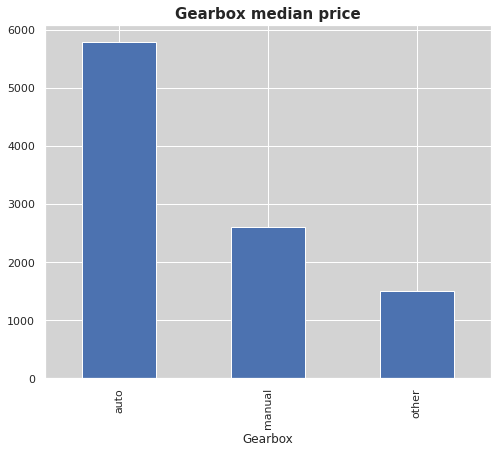

In [127]:
plt.figure(figsize=(8,6.5))
plt.title('Gearbox median price', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
df.groupby('Gearbox')['Price'].median().plot(kind='bar')
plt.show()

По гистограмме видно, что автоматическая коробка передач дороже ручной

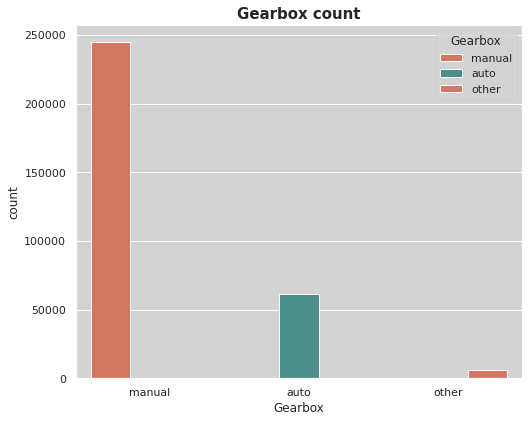

In [128]:
palette_features = ['#E56B51', '#409996']
sns.set(rc={'axes.facecolor':'lightgray'}) #background color of all plots

plt.figure(figsize=(8,6.5)) 
plt.title('Gearbox count', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
ax = sns.countplot(data = df, x = 'Gearbox', hue = 'Gearbox', palette=palette_features)

По гистограмме видно, что больше всего продается машин с ручной коробкой передач

### Подготовлю выборки для обучения моделей.

Закодирую катеогориальные значения

In [ ]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_other,Repaired_yes
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,12,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,125000,3,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,3,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')

In [ ]:
features_new_df = df.drop(['Price'], axis=1) 
target_new_df = df['Price']

In [ ]:
features_train_new_df, x_valid_new_df, target_train_new_df, y_valid_new_df = train_test_split(
   features_new_df, target_new_df, test_size = 0.4, random_state=42)

In [ ]:
features_valid_new_df, features_test_new_df, target_valid_new_df, target_test_new_df = train_test_split(x_valid_new_df,y_valid_new_df,
                                                                            test_size=0.5, random_state=42)

Подготовила данные для работы с LightGBM

In [ ]:
features = df_ohe.drop(['Price'], axis=1) 
target = df_ohe['Price']

Делим данные на три выборки для других моделей.

In [ ]:
features_train, x_valid, target_train, y_valid = train_test_split(
   features, target, test_size = 0.4, random_state=42)

In [ ]:
features_valid, features_test, target_valid, target_test = train_test_split(x_valid,y_valid,
                                                                            test_size=0.5, random_state=42)

In [ ]:
print(f'Размер обучающей выборки составляет: {features_train.shape[0] / len(df):.1%}')
print(f'Размер валидной выборки составляет: {features_valid.shape[0] / len(df):.1%}')
print(f'Размер тестовой выборки составляет: {features_test.shape[0] / len(df):.1%}')

Размер обучающей выборки составляет: 60.0%
Размер валидной выборки составляет: 20.0%
Размер тестовой выборки составляет: 20.0%


In [ ]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(177438, 308)
(177438,)
(59146, 308)
(59146,)


Масштабирую количественные признаки

In [ ]:
pd.options.mode.chained_assignment = None

numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric])

## Обучим модели

# LGBM МОДЕЛЬ

In [ ]:
categorical_feature = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand']  

Обучаю первую модель на тренировочных данных

In [ ]:
 %%time

    hyper_params = {
     'task': 'train',
     'boosting_type': 'gbdt',
     'objective': 'regression',
     'metric': ['rmse'],
     'learning_rate': 0.01,
     'verbose': 10,
     "max_depth": 8,
     "num_leaves": 128,  
     "max_bin": 512,
     'num_boost_round': 1000,
     'force_col_wise': 'true'
 }

LGBM_model = LGBMRegressor(**hyper_params, random_state=42)
LGBM_model.fit(features_train_new_df, target_train_new_df, categorical_feature=categorical_feature, verbose=False)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1208: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'VehicleType']



CPU times: user 1min 3s, sys: 611 ms, total: 1min 4s
Wall time: 1min


LGBMRegressor(force_col_wise='true', learning_rate=0.01, max_bin=512,
              max_depth=8, metric=['rmse'], num_boost_round=1000,
              num_leaves=128, objective='regression', random_state=42,
              task='train', verbose=10)

RMSE на валидационной выборке 1565


In [ ]:
%%time

predictions_valid_LGBM = LGBM_model.predict(features_valid_new_df)
RMSE_LGBM = mean_squared_error(target_valid, predictions_valid_LGBM)**0.5
RMSE_LGBM

CPU times: user 17.1 s, sys: 25.9 ms, total: 17.1 s
Wall time: 8.97 s


1565.1716734794757

Подпирараю гиперпараметры с помощью Optuna

In [ ]:

param_l_gbm = {"learning_rate": optuna.distributions.FloatDistribution (0.005, 0.4),
               'n_estimators': optuna.distributions.IntDistribution (50,400),
               'colsample_bytree': optuna.distributions.FloatDistribution (0.3,1.0),
               'num_leaves': optuna.distributions.IntDistribution (10,100),
               'lambda_l1': optuna.distributions.FloatDistribution (0,0.8),
               'lambda_l2': optuna.distributions.FloatDistribution (0,0.8),
               'bagging_freq': optuna.distributions.IntDistribution (1,100), 
               'drop_rate': optuna.distributions.FloatDistribution (0.1,0.8)}
l_gbm = LGBMRegressor(objective='regression',random_state=42)
optuna_search = optuna.integration.OptunaSearchCV(l_gbm,param_l_gbm, cv=3, scoring='neg_mean_squared_error',n_trials=50)
optuna_search.fit(features_train_new_df, target_train_new_df)
best_params = optuna_search.best_params_
best_score = -(optuna_search.best_score_)
rmse = best_score**0.5

<ipython-input-130-686bfd44fa9b>:10: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2023-01-12 12:28:58,710] A new study created in memory with name: no-name-742e17fb-4b58-4da0-b93e-11bf4bfe6317
[I 2023-01-12 12:29:10,864] Trial 0 finished with value: -2503495.564798367 and parameters: {'learning_rate': 0.182177753058445, 'n_estimators': 375, 'colsample_bytree': 0.38147678531864837, 'num_leaves': 55, 'lambda_l1': 0.5381987653528437, 'lambda_l2': 0.12468469117719279, 'bagging_freq': 25, 'drop_rate': 0.45894034315524934}. Best is trial 0 with value: -2503495.564798367.
[I 2023-01-12 12:29:13,550] Trial 1 finished with value: -2837551.7533941157 and parameters: {'learning_rate': 0.14367738009396136, 'n_estimators': 89, 'colsample_bytree': 0.8055982215262365, 'num_leaves': 12, 'lambda_l1': 0.03225810949929882, 'lambda_l2': 0.6117632567158007, 'bagging_freq': 72, 'drop_rate': 0.29779485520346993}. Best is trial 0 wi

Лучшие параметры:

In [ ]:
best_params

{'learning_rate': 0.10556860936566016,
 'n_estimators': 336,
 'colsample_bytree': 0.6784812147380468,
 'num_leaves': 99,
 'lambda_l1': 0.5607773664133455,
 'lambda_l2': 0.08560064904855023,
 'bagging_freq': 18,
 'drop_rate': 0.7303188844937601}

RMSE улучшилось 1537

In [ ]:
rmse

1537.9288212815395

Используя лучшие параметры из Оптуны, делаю предсказание на валидационной выборке

In [ ]:
%%time
LGBM_mode2 = LGBMRegressor(**best_params, random_state=42)
LGBM_mode2.fit(features_train_new_df, target_train_new_df, categorical_feature=categorical_feature, verbose=False)

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1208: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'VehicleType']



CPU times: user 7.64 s, sys: 132 ms, total: 7.77 s
Wall time: 4.07 s


LGBMRegressor(bagging_freq=18, colsample_bytree=0.6784812147380468,
              drop_rate=0.7303188844937601, lambda_l1=0.5607773664133455,
              lambda_l2=0.08560064904855023, learning_rate=0.10556860936566016,
              n_estimators=336, num_leaves=99, random_state=42)

RMSE модели с подобранными гиперпараметрами на валидацонной выборке 1529, у модели с начальными параметрами 1537

In [ ]:
%%time
predictions_valid_LGBM1 = LGBM_mode2.predict(features_valid_new_df)
RMSE_LGBM1 = mean_squared_error(target_valid, predictions_valid_LGBM1)**0.5
RMSE_LGBM1

CPU times: user 3.21 s, sys: 8.87 ms, total: 3.22 s
Wall time: 1.71 s


1529.713754590775

# МОДЕЛЬ ЛИНЕЙНАЯ РЕГРЕССИЯ

In [ ]:
LRmodel = LinearRegression()

In [ ]:
%%time

LRmodel.fit(features_train, target_train)

CPU times: user 9.95 s, sys: 1.15 s, total: 11.1 s
Wall time: 6.43 s


LinearRegression()

In [ ]:
%%time

predictions_valid_LR = LRmodel.predict(features_valid)
RMSE_LR = mean_squared_error(target_valid, predictions_valid_LR)**0.5
RMSE_LR

CPU times: user 89.6 ms, sys: 59.4 ms, total: 149 ms
Wall time: 90.8 ms


2591.4353011674784

На модели линейной регресси получили результат значительно хуже. Попробуем другую модель.

#RANDOM FOREST МОДЕЛЬ

In [ ]:
RFmodel_1 = RandomForestRegressor(random_state=42, n_estimators=10, max_depth = 10)

In [ ]:
%%time

RFmodel_1.fit(features_train, target_train)

CPU times: user 24.6 s, sys: 87.5 ms, total: 24.7 s
Wall time: 24.6 s


RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [ ]:
%%time

predictions_valid_RF = RFmodel_1.predict(features_valid)
RMSE_RF = mean_squared_error(target_valid, predictions_valid_RF)**0.5
RMSE_RF

CPU times: user 170 ms, sys: 47.9 ms, total: 218 ms
Wall time: 221 ms


1898.5727106307374

На первоначальной модели случайный лес получили ошибку меньше 1898. Попробуем туже модель с другими параметрами.

C помощью Grid Search подбираем гиперпараметры

In [ ]:
regressor = RandomForestRegressor() 
hyperparams = [{ 'n_estimators': [10,15,20],
                'max_depth':[10,20,30], 
                'random_state':[42]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print(clf.best_params_)

{'max_depth': 30, 'n_estimators': 20, 'random_state': 42}


In [ ]:
RFmodel_2 = RandomForestRegressor(random_state=42, n_estimators=20, max_depth = 30)

In [ ]:
%%time

RFmodel_2.fit(features_train, target_train)

CPU times: user 1min 25s, sys: 122 ms, total: 1min 25s
Wall time: 1min 26s


RandomForestRegressor(max_depth=30, n_estimators=20, random_state=42)

In [ ]:
%%time

predictions_valid_RF = RFmodel_2.predict(features_valid)
RMSE_RF2 = mean_squared_error(target_valid, predictions_valid_RF)**0.5
RMSE_RF2

CPU times: user 768 ms, sys: 13 ms, total: 781 ms
Wall time: 787 ms


1618.5142018607196

Ошибка модели стала ниже благодаря другим гиперпараметрам.

## Анализ моделей

In [ ]:
model_1 = {'Время обучения, сек': 4,
            'Время предсказания, сек': 1,
            'RMSE': RMSE_LGBM1.round()}
model_2 = {'Время обучения, сек': 6,
              'Время предсказания, сек': 0.9,
              'RMSE': RMSE_LR.round()}
model_3 = {'Время обучения, сек': 86,
              'Время предсказания, сек': 0.7 ,
              'RMSE': RMSE_RF2.round()}

In [ ]:
Models = pd.DataFrame([model_1, model_2, model_3], 
                      index=['LightGBM', 'LinearRegression', 'RandomForest'])

In [ ]:
Models

,"Время обучения, сек","Время предсказания, сек",RMSE
LightGBM,4,1.00,1530.00
LinearRegression,6,0.90,2591.00
RandomForest,86,0.70,1619.00


Итак, модели обучены. Исходя из таблице выше можно сделать вывод, что:

Самое высокое качество предсказания у модели LightGBM

Самое быстрое время обучения и предсказания у модели LinearRegression, но при этом низкое качество

Исходя из таблицы, то по всем трём параметрам выигрывает RandomForest, хоть и время обучения у неё выше, но качество и скорость предсказания достаточно высокие. Так что можно сделать вывод, что наилучшая модель для заказчика это RandomForest.

In [ ]:
%%time

predictions_test_LGBM = LGBM_mode2.predict(features_test_new_df)
RMSE = mean_squared_error(target_test_new_df, predictions_test_LGBM)**0.5
RMSE

CPU times: user 2.86 s, sys: 10.7 ms, total: 2.87 s
Wall time: 1.74 s


1489.5993231539605

RMSE на тестовой выборке показало практически такой же результат, как и на валидационной.